In [51]:
import seaborn as sns
import addcopyfighandler
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nw

import sklearn
from sklearn.preprocessing import LabelEncoder  
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import mysql.connector


import matplotlib.pyplot as plt

from scipy import integrate, stats
from app import app
from app import db

from scipy.signal import find_peaks
from scipy.stats import iqr
import TraceFeatures

# Regression models
import statsmodels.stats as sms
import statsmodels.api as sm
from statsmodels.formula.api import ols
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

# Save model
import pickle

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
print(os.environ["PATH"])

import app.Develops.OpenStreetMaps.associate_edges_to_operation as associate

# The OSM Graph
class OSM:
    graphpath = app.root_path + '/Develops/data/medellin.graphml'
    print('Empezando a cargar ')
    G = ox.load_graphml(graphpath)
    print('termina de cargar ')

C:\Users\Santiago\.conda\envs\ox;C:\Users\Santiago\.conda\envs\ox\Library\mingw-w64\bin;C:\Users\Santiago\.conda\envs\ox\Library\usr\bin;C:\Users\Santiago\.conda\envs\ox\Library\bin;C:\Users\Santiago\.conda\envs\ox\Scripts;C:\Users\Santiago\.conda\envs\ox\bin;C:\ProgramData\Anaconda3\condabin;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2\bin;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2\libnvvp;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0;C:\Windows\System32\OpenSSH;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\Program Files\NVIDIA Corporation\NVIDIA NvDLISR;C:\Program Files\Git\cmd;C:\Program Files\PuTTY;C:\Program Files\OpenVPN\bin;C:\Program Files (x86)\Eclipse\Sumo\bin;C:\Program Files (x86)\Eclipse\Sumo\tools;C:\Program Files\NVIDIA Corporation\Nsight Compute 2020.3.0;C:\Program Files\nodejs;C:\Program Files\MySQL\MySQL Shell 8.0\bin;C:\Users\Santiago\AppData\Local\Microsoft\WindowsApps;C:\Prog

# Read operation data

In [52]:
print(app.root_path)
new_df = pd.read_csv(app.root_path+'/DataBackup/updated_vehicle_operation.csv')
old_df = pd.read_csv(app.root_path+'/DataBackup/updated_old_vehicle_operation.csv', index_col='id')


new_df.dropna(axis=1, how='all', inplace=True)
old_df.dropna(axis=1, how='all', inplace=True)


C:\Users\Santiago\OneDrive - Universidad EAFIT\Documentos\Universidad\Maestria\Aplicacion\monitoreogrid\app


C:\Users\Santiago\.conda\envs\ox\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (85,88) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\Santiago\.conda\envs\ox\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (83) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Read directly from Db and assign osm EDGES info

In [30]:
cnx = mysql.connector.connect(user='admin', password='actuadores',
                              host='157.230.209.3',
                              database='monitoreodb')

query = "SELECT * from operation WHERE vehicle_id = 'FVQ731'"
FVQ731 = pd.read_sql_query(query, cnx, index_col='id')
FVQ731.dropna(axis=1, how='all', inplace=True)
FVQ731

cnx = mysql.connector.connect(user='admin', password='actuadores',
                                  host='157.230.209.3',
                                  database='monitoreodb')

print('conexión ok db')
query = "SELECT * from operation WHERE vehicle_id = 'FVQ731'"
FVQ731 = pd.read_sql_query(query, cnx, index_col='id')
FVQ731.dropna(axis=1, how='all', inplace=True)

UG = ox.get_undirected(OSM.G).edges(keys=True, data=True)
print('Convierte el grafo')

FVQ731.dropna(subset=['power_kw', 'odometer'], inplace=True)
FVQ731 = associate.add_osmn_attributes(FVQ731, UG, OSM.G)
FVQ731['odometer_calc'] = FVQ731['run'].cumsum()

conexión ok db
Convierte el grafo
empieza nearest_edges


30536

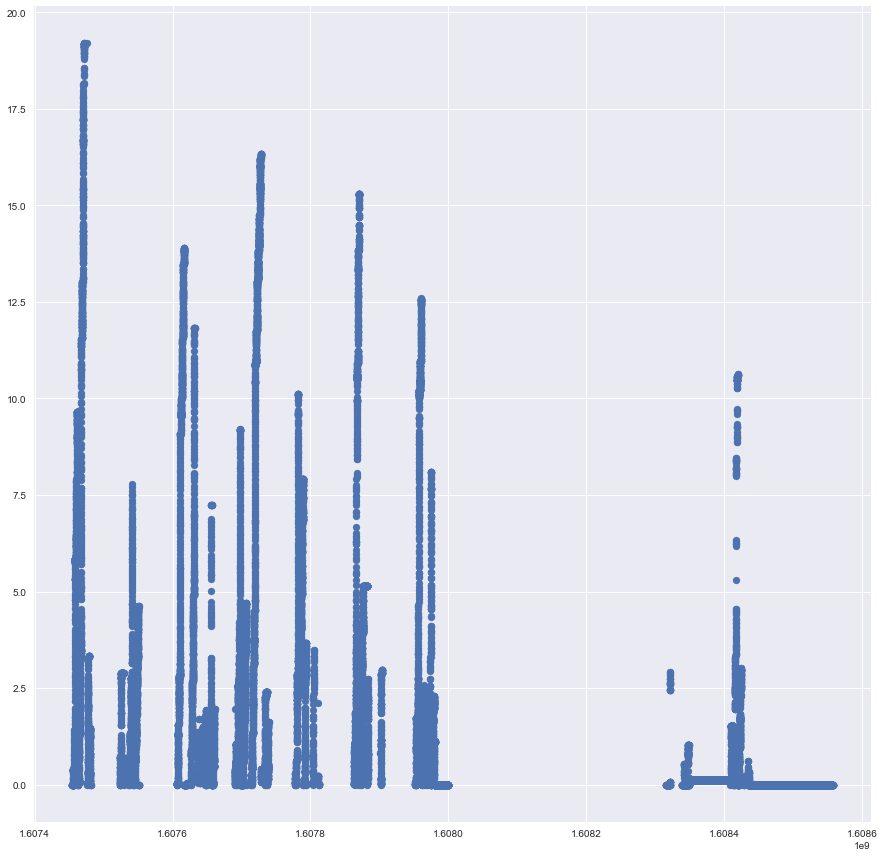

In [418]:
enrgy_n = new_df[new_df['energy'] > -2.51109e+20][['operative_state', 'timestamp2',
       'slope', 'speed', 'odometer', 'user_id',
       'power_kw', 'capacity', 'soc',
       'voltage', 'current', 'consumption',
       'energy', 'rpm',
       'drivemode',
       'mean_acc', 'run',
       'mean_speed']]
plt.figure(figsize=[15,15])
plt.scatter(x=enrgy_n.timestamp2, y=enrgy_n.energy)
len(enrgy_n.energy)


# Validation of run metric

In [54]:

print(old_df['run'][old_df['vehicle_id']=='FSV110'].sum()/1000)
print(old_df['run'][old_df['vehicle_id']=='GHW284'].sum()/1000)
print(new_df['run'][new_df['vehicle_id']=='GHW284'].sum()/1000)


print(old_df['odometer'][old_df['vehicle_id']=='FSV110'].iloc[-1] - old_df['odometer'][old_df['vehicle_id']=='FSV110'].iloc[0])
print(old_df['odometer'][old_df['vehicle_id']=='GHW284'].iloc[-1] - old_df['odometer'][old_df['vehicle_id']=='GHW284'].iloc[0])
print(new_df['odometer'][new_df['vehicle_id']=='GHW284'].iloc[-1] - new_df['odometer'][new_df['vehicle_id']=='GHW284'].iloc[0])
print(FVQ731['odometer_calc'].iloc[-1]/1000 - FVQ731['odometer_calc'].iloc[0]/1000)


448.7245327608838
226.0294186408727
975.3872763571566
443.0
197.0
938.7399999999998
86.52002423882887


In [55]:
mixed_operation = old_df.append(new_df, ignore_index=True)
mixed_operation = mixed_operation[mixed_operation.power_kw != 0]

#### Corrigiendo usuarios

In [56]:

mixed_operation.user_id[(mixed_operation.user_id == 'Juan') &
                        (mixed_operation.vehicle_id =='FSV110')] = 'Santiago_Echavarria_FSV110'

mixed_operation.user_id[(mixed_operation.user_id == 'Juan') &
                        (mixed_operation.vehicle_id =='GHW284')] = 'Juan_David_Mira_Alq2'

mixed_operation.user_id[(mixed_operation.user_id == 'Juan_David_Mira') &
                        (mixed_operation.timestamp2 > 1.608e9)] = 'Juan_David_Mira_03'

mixed_operation.user_id[(mixed_operation.user_id == 'Juan_David_Mira')] = 'Juan_David_Mira_01'

mixed_operation.user_id[(mixed_operation.user_id == 'Juan_Mira')] = 'Juan_David_Mira_02'

mixed_operation.user_id.unique()

<ipython-input-56-d625cac47cf9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mixed_operation.user_id[(mixed_operation.user_id == 'Juan') &
<ipython-input-56-d625cac47cf9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mixed_operation.user_id[(mixed_operation.user_id == 'Juan_David_Mira') &
<ipython-input-56-d625cac47cf9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mixed_operation.user_id[(mixed_operation.user_id == 'Juan_Da

array(['Santiago_Echavarria_FSV110', 'Juan_David_Mira_Alq2',
       'Ricardo_Mejia', 'Santiago_Echavarria_01', 'Santiago_Echavarria',
       'Jose_Alejandro_Montoya', 'Juan_Gregorio_Arrieta',
       'Juan_David_Mira_01', 'Mauricio_Fernandez', 'Sergio',
       'Jesus_Villa', 'Juan_David_Mira_02', 'Juan_David_Ochoa',
       'David_Rios', 'Ana_Cristina_G', 'Juan_David_Mira_03',
       'Esterban_Betancur'], dtype=object)

#### Corrigiendo los pesos
https://verne.elpais.com/verne/2016/04/19/articulo/1461079768_768006.html 61kg para mujeres y 67kg para hombres

In [57]:
# Para el ZOE y LEAF respectivamente 
mixed_operation.mass[mixed_operation.mass == 170] = 1502
mixed_operation.mass[mixed_operation.mass == 1528] = 1502
mixed_operation.mass[mixed_operation.mass == 1584] = 1904

# Con acompañante mujer
mixed_operation['mass'] = np.where((
    (mixed_operation['user_id'] == 'Juan_David_Ochoa') |
    (mixed_operation['user_id'] == 'Ricardo_Mejia') |
    (mixed_operation['user_id'] == 'Jose_Alejandro_Montoya') |
    (mixed_operation['user_id'] == 'Ana_Cristina_G') | 
    (mixed_operation['user_id'] == 'Esterban_Betancur') | 
    (mixed_operation['user_id'] == 'Juan_Gregorio_Arrieta') |
    (mixed_operation['user_id'] == 'Sergio')),mixed_operation.mass + 61 + 67, mixed_operation.mass)

# Con acompañante hombre
mixed_operation['mass'] = np.where((
    (mixed_operation['user_id'] == 'Juan_David_Mira_01')),
    mixed_operation.mass + 67 + 67, mixed_operation.mass)

# Los que manejaron solos (menos peso)
mixed_operation['mass'] = np.where((
    (mixed_operation['user_id'] == 'Santiago_Echavarria_FSV110') |
    (mixed_operation['user_id'] == 'Santiago_Echavarria_01') |
    (mixed_operation['user_id'] == 'Santiago_Echavarria') |
    (mixed_operation['user_id'] == 'Juan_David_Mira_Alq2') |
    (mixed_operation['user_id'] == 'Juan_David_Mira_02') |
    (mixed_operation['user_id'] == 'Jesus_Villa')),
    mixed_operation.mass + 62, mixed_operation.mass)

# Otros que manejaron solos 
mixed_operation['mass'] = np.where((
    (mixed_operation['user_id'] == 'David_Rios') |
    (mixed_operation['user_id'] == 'Mauricio_Fernandez')),
    mixed_operation.mass + 67, mixed_operation.mass)

mixed_operation.to_csv( app.root_path+'/DataBackup/mixed_operation.csv', index=False)


<ipython-input-57-9bf05633c338>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mixed_operation.mass[mixed_operation.mass == 1528] = 1502
<ipython-input-57-9bf05633c338>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mixed_operation.mass[mixed_operation.mass == 1584] = 1904


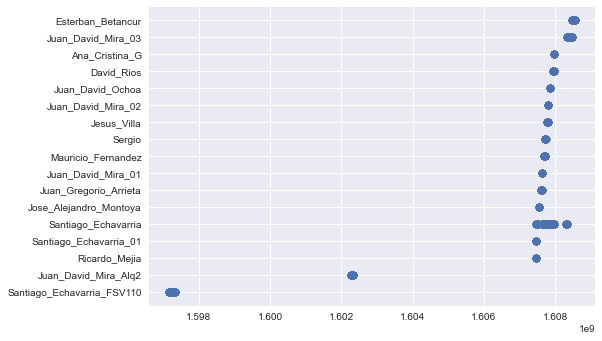

In [419]:
plt.scatter(x=mixed_operation.timestamp2, y=mixed_operation.user_id)

# Segmentation

In [58]:
def gen_trace(df):
    try:
        df.drop(columns='Unnamed: 0', inplace=True)
        df.drop(columns='id', inplace=True)
    except KeyError:
        pass
    trace_id = 1
    aux_trace_id = -1
    trace_array = np.array([])
    suma = 0
    old_name = ''

    for index, row in df.iterrows():
    #for index, row in test.iterrows():
        suma = suma + row['run']
        #row['slope']
        trace_array = np.append(trace_array, aux_trace_id)
        nan = (row['name'] != row['name'])
        
        # Si recorre mas de 300 metros - cambiele el id del segmento actual de aux a definitivo para que se tenga en cuenta
        if suma >=800:
            trace_array = np.where(trace_array == aux_trace_id, trace_id, trace_array)
            
        # Si cambia de vía - empiece un nuevo tramo se escoge 1200 para ver cambios en consumo
        if suma >=1000 or (old_name != row['name'] and not nan) or row['operative_state'] == 3:  # pendiente
        #if suma >=1100: # or (old_name != row['name'] and not nan):  # pendiente
            suma = 0
            trace_id += 1
            aux_trace_id -= 1

        old_name = row['name']

    print(trace_array)
    try:
        df.drop(["trace_id"], axis=1, inplace=True)
    except KeyError:
        pass
    df.insert(2, "trace_id", trace_array, True)
   
    return df

In [112]:
mixed_operation_trace = gen_trace(mixed_operation)

[-1.000e+00  2.000e+00  2.000e+00 ... -5.865e+03 -5.865e+03 -5.865e+03]


In [8]:
# Para correr todo con un df diferente
FVQ731_trace = gen_trace(FVQ731)
mixed_operation_trace = FVQ731_trace

[  -1.   -2.   -2. ... -535. -535. -535.]


# Relacion entre pedal de aceleración y potencia


Corr with power =  0.7611497846073747
P value =  9.73013158955793e-144
Corr with current =  0.34712148500577955
P value =  8.411064548088247e-23
Corr with acc =  0.002444903101466814
P value =  0.9465275387034696
len =  755


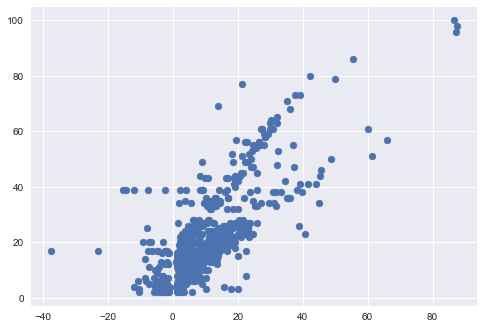

In [420]:
FRV020 = mixed_operation_trace[
    (mixed_operation_trace['vehicle_id'] == 'FRV020') &
    ((mixed_operation_trace['power_kw'] < -1) | (mixed_operation_trace['power_kw'] > 1)) &
    (mixed_operation_trace['throttle'] > 1) &
    ((mixed_operation_trace['throttle'] < 29) | (mixed_operation_trace['throttle'] > 31))]
FRV020_esteban = FRV020[FRV020['user_id'] == 'Esteban_Betancur']
plt.figure()
plt.scatter(x=FRV020['power_kw'], y=FRV020['throttle'])

#Correlacion
corr_coef, p_value = stats.pearsonr(FRV020['power_kw'].to_numpy(), FRV020['throttle'])
print('Corr with power = ',corr_coef)
print('P value = ',p_value)

corr_coef_curr, p_value_curr = stats.pearsonr(FRV020['current'].to_numpy(), FRV020['throttle'])
print('Corr with current = ',corr_coef_curr)
print('P value = ',p_value_curr)

corr_coef_acc, p_value_acc = stats.pearsonr(FRV020['mean_acc'].to_numpy(), FRV020['throttle'])
print('Corr with acc = ',corr_coef_acc)
print('P value = ',p_value_acc)
print('len = ',len(FRV020))

In [113]:
classifier_df = mixed_operation_trace[mixed_operation_trace['trace_id'] > 0]
print(len(classifier_df))

traces = classifier_df.groupby(['trace_id'])
len(traces)

14309


1107

In [124]:


def calc_shortest_path(G, lat_o, lon_o, lat_d, lon_d):
    point_o = (lat_o, lon_o)
    point_d = (lat_d, lon_d)
    nearest_node_o = ox.distance.get_nearest_node(G, point_o, method='haversine', return_dist=True)
    nearest_node_d = ox.distance.get_nearest_node(G, point_d, method='haversine', return_dist=True)
    try:
        shortest_path = nw.algorithms.shortest_paths.weighted.dijkstra_path(G=G, source=nearest_node_o[0],
                                                                            target=nearest_node_d[0],
                                                                            weight='travel_time')
        traffic_lights = 0
        for node in shortest_path:
            try:
                G.nodes[node]['highway']
                traffic_lights += 1
            except Exception:
                pass

        return shortest_path, traffic_lights
    except Exception:
        return 0, 0
    

def peak_features(trace, var, limit_u, limit_l, name):
    peaks, peak_values = find_peaks(var, height=limit_u)  # mas de nedio acelerador
    valleys, valleys_values = find_peaks(-var, height=limit_l)
    num_peaks_minuto = 60 * len(peaks) / (trace['timestamp2'].iloc[-1] - trace['timestamp2'].iloc[0])
    num_valleys_minuto = 60 * len(valleys) / (trace['timestamp2'].iloc[-1] - trace['timestamp2'].iloc[0])

    prom_sobrepaso_peak = np.mean(peak_values['peak_heights']) / limit_u
    if np.isnan(prom_sobrepaso_peak):
        prom_sobrepaso_peak = 1

    # Promedio de sobrepaso de la referencia máxima de frenado
    prom_sobrepaso_valley = np.mean(valleys_values['peak_heights']) / limit_l
    if np.isnan(prom_sobrepaso_valley):
        prom_sobrepaso_valley = 1

    # Promedio de valor absoluto de la aceleración
    prom_abs = np.mean(np.absolute(var))
    std = np.std(var)
    max_val = np.max(var)
    return num_peaks_minuto, num_valleys_minuto, prom_sobrepaso_peak, prom_sobrepaso_valley, prom_abs, std, max_val


def feature_extraction(trace):
    trace['cumulative_distance'] = trace['run'].cumsum()

    # Picos aceleraciones y frenadas
    acc = trace['mean_acc'].to_numpy()
    num_acc_min, num_acc_fr_min, prom_sobrepaso_acc, prom_sobrepaso_fren, prom_abs_acc, std_acc, max_acc = peak_features(
        trace, acc, 1, 1, ',mean_acc')  # mas de nedio acelerador

    # Derivative of da/dt to find Jerk  - partir en otra función
    time_indexed_acc = pd.Series(acc, index=trace['timestamp2'])
    jerk = time_indexed_acc.diff().to_numpy()
    num_jerk_acc_min, num_jerk_freno_min, prom_sobrepaso_jerk_acc, prom_sobrepaso_jerk_freno, prom_abs_jerk, std_jerk, max_jerk = peak_features(
        trace, jerk[1:], 1.5, 1.5, 'jerk')  # mas de nedio acelerador

    # Picos corriente
    current = trace['current'].to_numpy()
    num_current_min, num_current_fr_min, prom_sobrepaso_current, prom_sobrepaso_current_fr, prom_abs_current, std_current, max_current = peak_features(
        trace, current, 60, 100, 'current')  # mas de nedio acelerador

    slope = np.mean(trace['slope'])

    power_nominal_zoe = 65.6216
    power_nominal_leaf = 81.2813
    if trace['vehicle_id'].iloc[0] == 'FRV020':
        power_nominal = power_nominal_leaf
    else:
        power_nominal = power_nominal_zoe
        
    mass = trace['mass'].iloc[0]

#     std_power = np.std(trace['power_kw']) / power_nominal
#     iqr_power = iqr(trace['power_kw']) / power_nominal
#     prom_abs_power = np.mean(np.absolute(trace['power_kw'])) / power_nominal
#     max_power = np.max(trace['power_kw']) / power_nominal
#     min_power = np.min(trace['power_kw']) / power_nominal

    # Medidas de potencia específica
    std_power = np.std(trace['power_kw']) / 1
    iqr_power = iqr(trace['power_kw']) / 1
    prom_abs_power = np.mean(np.absolute(trace['power_kw'])) / 1
    max_power = np.max(trace['power_kw']) / 1
    min_power = np.min(trace['power_kw']) / 1


    # With trip energy used
    consumption1 = trace['energy'].iloc[-1] - trace['energy'].iloc[0]

    # With battery capacity
    consumption2 = trace['capacity'].iloc[0] - trace['capacity'].iloc[-1]

    # With power integration
    consumption3 = integrate.cumtrapz(trace['power_kw'], trace['timestamp2'])
    consumption3 = (consumption3[-1] - consumption3[0]) / 3600

    if slope < 0:
        consumption1 = consumption3

    # Average specific consumption kWh / kg
    # consumption = (0.23* consumption1 + 0.3*consumption2 + 0.47*consumption3) / 1
    consumption = consumption2
    kms = trace['cumulative_distance'].iloc[-1] / 1000
    
    # kWh / kg*km  --> Energy per km per kg
    consumption_per_km = consumption / kms
    std_current_std_jerk = std_current * std_jerk
    max_speed = np.max(trace['speed'])
    mean_speed = np.mean(trace['speed'])
    median_speed = np.median(trace['speed'])
    std_speed = np.std(trace['speed'])
    time = trace['timestamp2'].iloc[-1] - trace['timestamp2'].iloc[0]

    # This indicator detects traffic (including red lights)
    stopped_time = 0
    old_time = trace['timestamp2'].iloc[0]
    prev = False
    
    for index, row in trace[['timestamp2', 'mean_speed']].iterrows():
        if row['mean_speed'] < 2:
            if prev:
                stopped_time += row['timestamp2'] - old_time

            old_time = row['timestamp2']
            prev = True
        else:
            prev = False
    idle_time = stopped_time / time
    traffic_factor = mean_speed / std_speed

    mean_temp = trace['ext_temp'].mean()
    nominal_speed = trace['speed_kph'].iloc[0]

    speed_ind = nominal_speed / np.max(trace['speed'])
    try:
        test_id = trace['test_id'].iloc[0]
    except KeyError:
        test_id = 0

    a, n_lights = calc_shortest_path(OSM.G, trace['latitude'].iloc[0], trace['longitude'].iloc[0],
                                     trace['latitude'].iloc[-1], trace['longitude'].iloc[-1])

    return [num_acc_min, num_acc_fr_min, prom_sobrepaso_acc, prom_sobrepaso_fren, prom_abs_acc, std_acc,
            num_jerk_acc_min, num_jerk_freno_min, prom_sobrepaso_jerk_acc,
            prom_sobrepaso_jerk_freno, prom_abs_jerk, std_jerk, std_power, prom_abs_power, consumption,
            kms, consumption_per_km, num_current_min, num_current_fr_min, prom_sobrepaso_current,
            prom_sobrepaso_current_fr, prom_abs_current, std_current, std_current_std_jerk,
            trace['highway'].iloc[0], slope, nominal_speed, max_current, max_jerk, max_acc,
            max_power, min_power, max_speed, mean_speed, std_speed, iqr_power, trace['soc'].mean(),
            mean_temp, time, idle_time,
            traffic_factor, trace['user_id'].iloc[0], trace['vehicle_id'].iloc[0], speed_ind, test_id,
            trace['timestamp'].iloc[-1],  trace['mass'].iloc[-1], n_lights, trace['odometer'].iloc[-1]]


def generate_features_df(lst):
    cols = ['num_acc_min', 'num_acc_fr_min', 'prom_sobrepaso_acc', 'prom_sobrepaso_fren', 'prom_abs_acc',
            'std_acc', 'num_jerk_acc_min', 'num_jerk_freno_min', 'prom_sobrepaso_jerk_acc',
            'prom_sobrepaso_jerk_freno', 'prom_abs_jerk', 'std_jerk', 'std_power', 'prom_abs_power',
            'consumption', 'kms', 'consumption_per_km', 'num_current_min', 'num_current_fr_min',
            'prom_sobrepaso_current', 'prom_sobrepaso_current_fr', 'prom_abs_current', 'std_current',
            'std_current_std_jerk', 'highway', 'slope', 'nominal_speed', 'max_current', 'max_jerk', 'max_acc',
            'max_power', 'min_power', 'max_speed', 'mean_speed', 'std_speed', 'iqr_power', 'mean_soc', 'mean_temp', 'travel_time',
            'idle_time', 'traffic_factor', 'user_id', 'vehicle_id', 'speed_ind', 'test_id', 'end_time', 'mass', 'lights',
            'end_odometer']

    return pd.DataFrame(lst, columns=cols)



In [472]:
lst = []
for index, trace in traces:
    if index > 0 and len(trace) > 1:
        lst.append(feature_extraction(trace))

features = generate_features_df(lst)
features


C:\Users\Santiago\.conda\envs\ox\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Santiago\.conda\envs\ox\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-124-7453322aab0d>:131: RuntimeWarning: invalid value encountered in double_scalars
  traffic_factor = mean_speed / std_speed
<ipython-input-124-7453322aab0d>:136: RuntimeWarning: divide by zero encountered in double_scalars
  speed_ind = nominal_speed / np.max(trace['speed'])


,num_acc_min,num_acc_fr_min,prom_sobrepaso_acc,prom_sobrepaso_fren,prom_abs_acc,std_acc,num_jerk_acc_min,num_jerk_freno_min,prom_sobrepaso_jerk_acc,prom_sobrepaso_jerk_freno,...,idle_time,traffic_factor,user_id,vehicle_id,speed_ind,test_id,end_time,mass,lights,end_odometer
0,0.000000,0.000000,1.00,1.0,0.091163,0.208262,0.000000,0.000000,1.000000,1.000000,...,0.667722,0.612218,Santiago_Echavarria_FSV110,FSV110,1.071429,0,2020-08-11 12:02:18,1564,0,2462.0
1,0.000000,0.000000,1.00,1.0,0.230000,0.293417,0.000000,0.000000,1.000000,1.000000,...,0.000000,10.182787,Santiago_Echavarria_FSV110,FSV110,0.895522,0,2020-08-11 12:03:07,1564,0,2463.0
2,0.000000,0.000000,1.00,1.0,0.268750,0.329638,0.000000,0.000000,1.000000,1.000000,...,0.000000,6.606790,Santiago_Echavarria_FSV110,FSV110,0.882353,0,2020-08-11 12:04:14,1564,0,2464.0
3,0.000000,0.000000,1.00,1.0,0.112500,0.144655,0.000000,0.000000,1.000000,1.000000,...,0.000000,8.177164,Santiago_Echavarria_FSV110,FSV110,0.923077,0,2020-08-11 12:05:10,1564,0,2465.0
4,0.000000,0.000000,1.00,1.0,0.300000,0.345292,0.000000,0.000000,1.000000,1.000000,...,0.000000,8.914875,Santiago_Echavarria_FSV110,FSV110,0.889831,0,2020-08-11 12:06:30,1564,0,2466.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1093,0.363636,0.363636,1.30,1.0,0.344687,0.463932,0.000000,0.363636,1.000000,1.266667,...,0.018182,1.351945,Esterban_Betancur,FRV020,1.355932,0,2020-12-20 11:59:05,2032,0,1008.0
1094,0.143885,0.000000,1.01,1.0,0.228039,0.327847,0.000000,0.000000,1.000000,1.000000,...,0.107914,0.881168,Esterban_Betancur,FRV020,1.000000,0,2020-12-20 12:13:41,2032,2,1008.0
1095,0.000000,0.000000,1.00,1.0,0.478571,0.690067,0.000000,0.000000,1.000000,1.000000,...,0.000000,7.668365,Esterban_Betancur,FRV020,0.625000,0,2020-12-20 12:16:20,2032,0,1008.0
1096,3.243243,0.000000,1.66,1.0,0.724286,0.944380,3.243243,1.621622,1.226667,1.273333,...,0.000000,11.874637,Esterban_Betancur,FRV020,0.645161,0,2020-12-20 12:16:59,2032,0,1008.0


count    788.000000
mean      79.727157
std       48.037474
min        4.000000
25%       51.000000
50%       66.000000
75%       94.000000
max      299.000000
Name: travel_time, dtype: float64

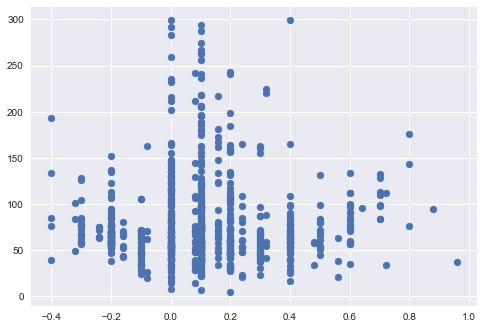

In [426]:
plt.scatter(x=features.consumption, y=features.travel_time)
features.travel_time.describe()

In [473]:
bc = features.copy()
#features=bc.copy()
features.mean_temp.fillna(value=np.mean(features.mean_temp), inplace=True)

In [474]:
features.lights[features.lights != 0].describe()


count    358.000000
mean       3.315642
std        2.179181
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       17.000000
Name: lights, dtype: float64

In [475]:
from sklearn.preprocessing import LabelEncoder  
features = features[features['kms'] <= 1.1]
features = features[(features['max_current'] < 250) ]
features = features[(features['travel_time'] < 300) ]

#features = features[(features['traffic_factor'] < 45) ]

# Cuando es cono 1200 mts
features = features[(features['consumption'] > -0.5) & (features['consumption'] < 1)]

# Cuando es con 300mts
#features = features[(features['consumption'] > -0.15) & (features['consumption'] < 0.4)]

#features = features[(features['consumption_per_km'] < 0.8) ]

features = features[features['std_acc'] != 0]

# Se eliminan los datos que tengan error de medición en la potencia
features = features[features['max_power'] != 0]

#features = features[features['vehicle_id'] != 'FRV020']

print(len(features))
features = features[(features['consumption_per_km'] > -4) | (features['consumption_per_km'] < 1) ].dropna()
print(len(features))

le = LabelEncoder()
features['highway_enc'] = le.fit_transform(features['highway'])
features['slope_cat'] = pd.cut(features["slope"], np.arange(-10,10.1,5) )
features['slope_cat'] = features['slope_cat'].astype('string')

# Wh/km
features['consumption_per_km'] = features['consumption_per_km']*1000

print('equal to 0 =',len(features[features['consumption'] == 0]))
print('different from 0 =', len(features[features['consumption'] != 0]))

features.corr()['consumption'].sort_values()

788
788
equal to 0 = 138
different from 0 = 650


traffic_factor              -0.150096
mean_soc                    -0.126443
speed_ind                   -0.079270
prom_sobrepaso_current_fr   -0.059161
end_odometer                -0.029593
highway_enc                 -0.020392
num_current_fr_min          -0.019260
nominal_speed                0.004133
idle_time                    0.011648
travel_time                  0.018579
mass                         0.025449
lights                       0.033964
mean_speed                   0.045044
prom_sobrepaso_acc           0.048198
num_acc_min                  0.055269
kms                          0.067864
prom_sobrepaso_jerk_freno    0.085741
prom_sobrepaso_jerk_acc      0.104246
num_jerk_acc_min             0.107775
max_acc                      0.107854
prom_sobrepaso_fren          0.111990
num_jerk_freno_min           0.134619
max_speed                    0.152607
std_speed                    0.157743
mean_temp                    0.161304
num_acc_fr_min               0.174727
max_jerk    

In [476]:
features.to_csv('features.csv', index= False)

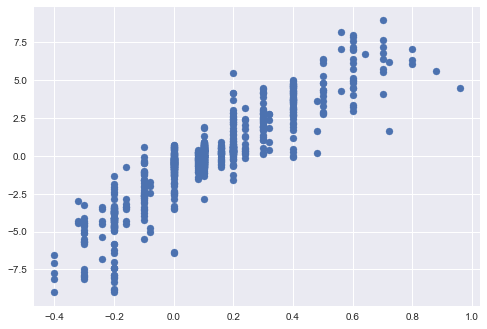

In [477]:
plt.scatter(x=features.consumption, y=features.slope)

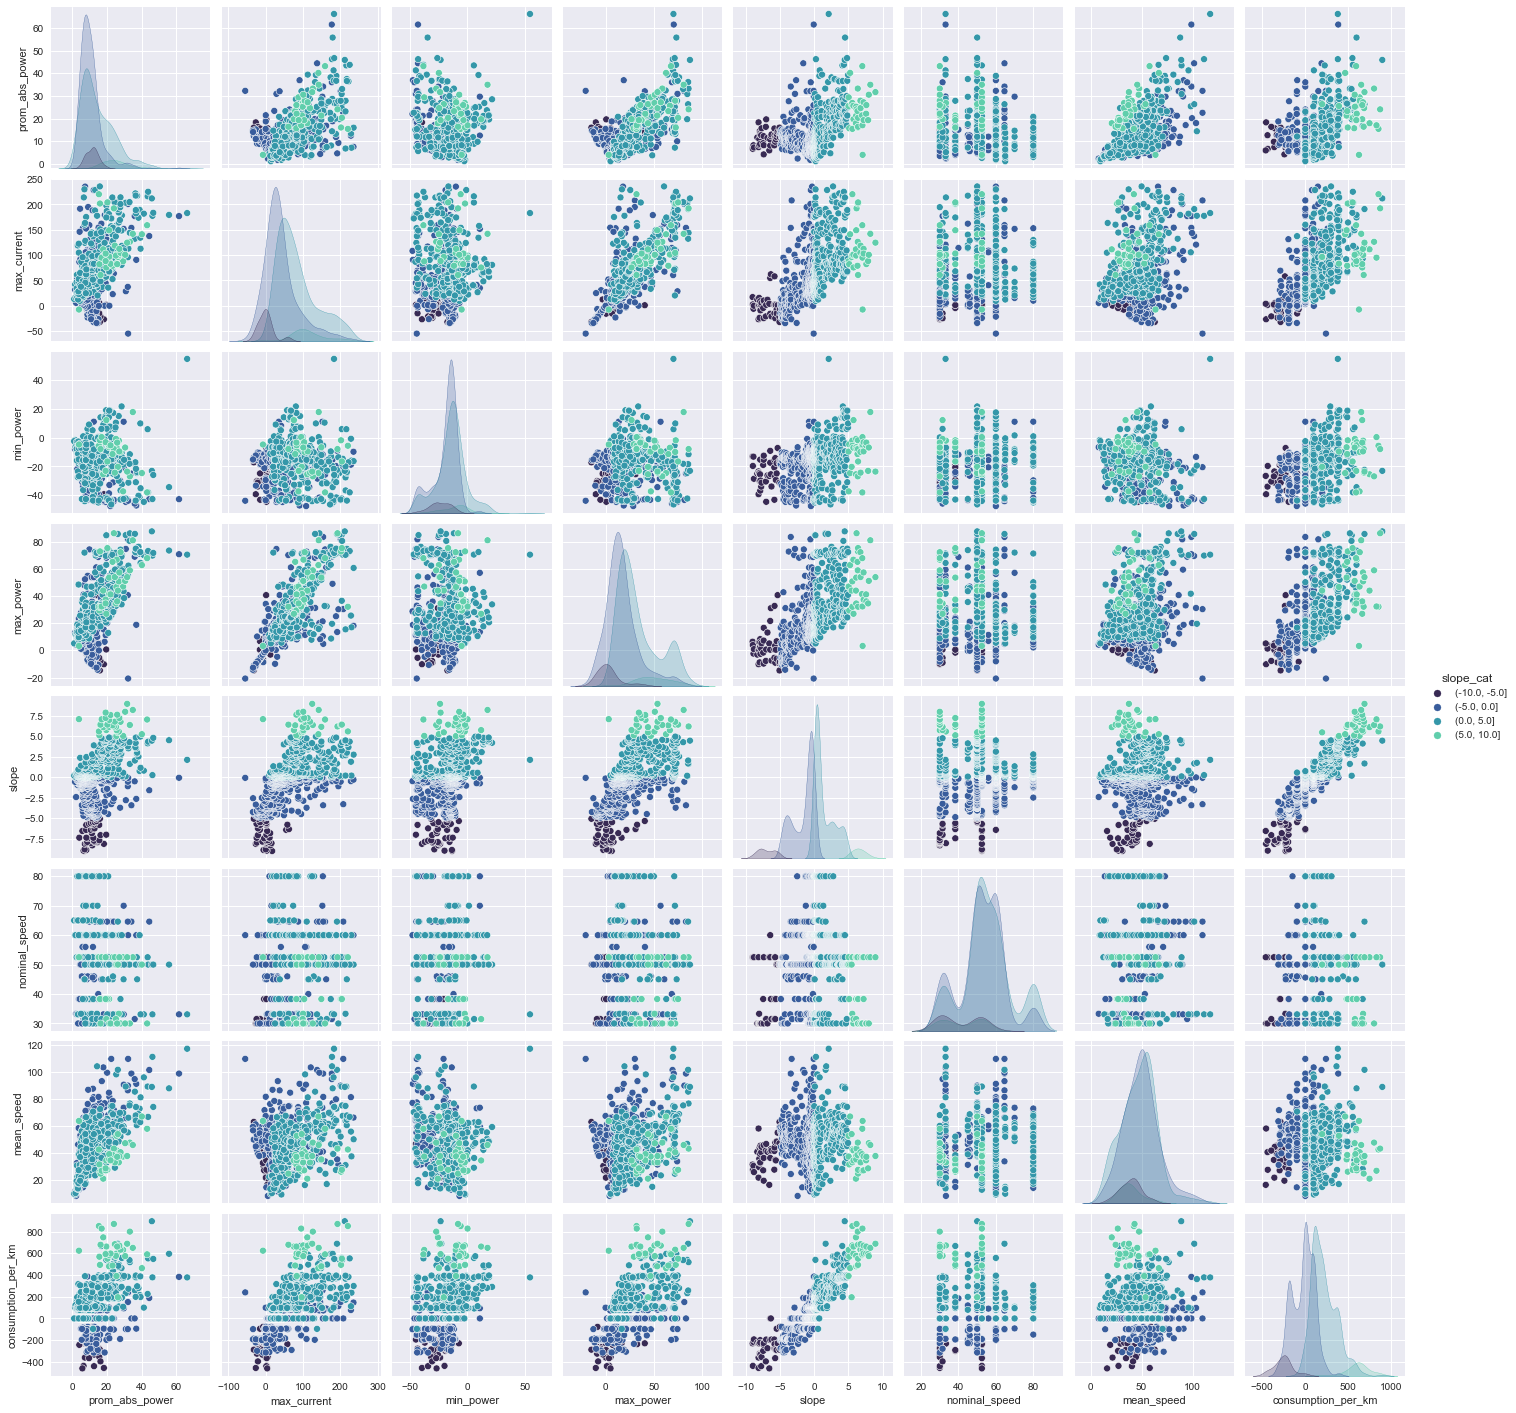

In [478]:
sns.pairplot(features.dropna().sort_values(['slope']), hue='slope_cat', palette='mako', vars=['prom_abs_power', 'max_current', 'min_power', 'max_power', 'slope', 'nominal_speed', 'mean_speed',
                                             'consumption_per_km'], kind= 'scatter')

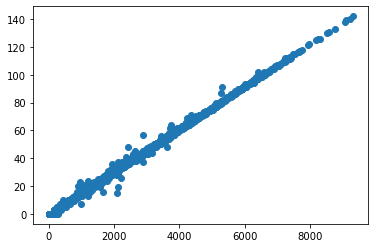

In [242]:
rpm = new_df[new_df.rpm > 0]
plt.scatter(x=rpm.rpm, y=rpm.speed)


<Figure size 720x720 with 0 Axes>

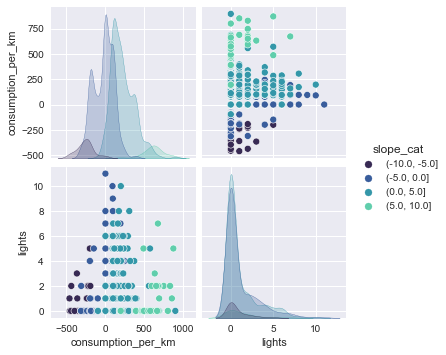

In [479]:
# plt.scatter(x=features.consumption_per_km, y=features.lights)
plt.figure(figsize=[10,10])
sns.pairplot(features.dropna().sort_values(['slope']), hue='slope_cat', palette='mako', vars=['consumption_per_km', 'lights'], kind='scatter')


# To implement - pace during route
### TellsF the user if his current rate is lower or upper to the estimated

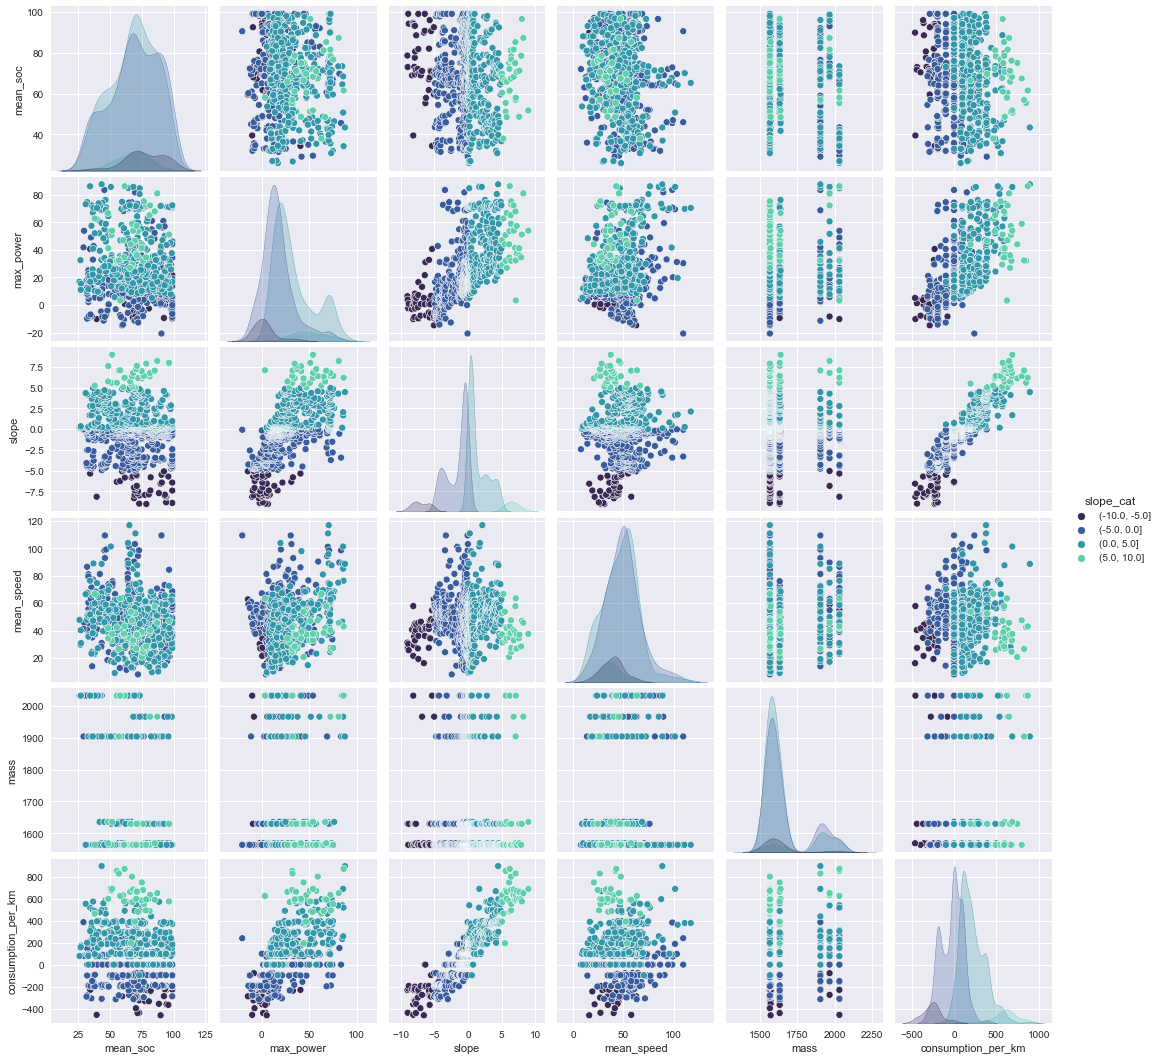

In [480]:
sns.pairplot(features.dropna().sort_values(['slope']), hue='slope_cat', palette='mako', vars=['mean_soc', 'max_power', 'slope', 'mean_speed', 'mass',
                                             'consumption_per_km'], kind='scatter')


In [465]:
features.user_id.unique()

array(['Santiago_Echavarria_measure', 'Santiago_Echavarria_test'],
      dtype=object)

['Santiago_Echavarria_FSV110' 'Juan_David_Mira_Alq2' 'Ricardo_Mejia'
 'Santiago_Echavarria_01' 'Santiago_Echavarria' 'Jose_Alejandro_Montoya'
 'Juan_Gregorio_Arrieta' 'Juan_David_Mira_01' 'Mauricio_Fernandez'
 'Sergio' 'Jesus_Villa' 'Juan_David_Mira_02' 'Juan_David_Ochoa'
 'David_Rios' 'Ana_Cristina_G' 'Juan_David_Mira_03' 'Esterban_Betancur']


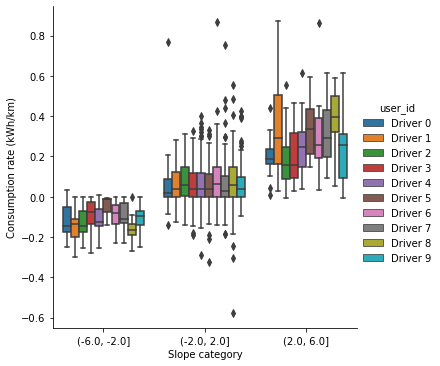

In [1197]:
x=features[(features['slope'] > -6) & (features['slope'] < 6)]
print(x.user_id.unique())
x = x[x['user_id'] != 'Juan_David_Mira_01']
x = x[x['user_id'] != 'Santiago_Echavarria_FSV110']

x = x[x['user_id'] != 'Santiago_Echavarria']
x = x[x['user_id'] != 'Santiago_Echavarria_01']  # Por ser muy atipico
x = x[x['user_id'] != 'Juan_David_Mira_01']
x = x[x['user_id'] != 'Juan_David_Mira_02']
x = x[x['user_id'] != 'Juan_David_Mira_03']
x = x[x['user_id'] != 'Juan_David_Mira_Alq2']

x.loc[x['user_id'] == 'Ricardo_Mejia', 'user_id'] = 'Driver 0'
x.loc[x['user_id'] == 'Jose_Alejandro_Montoya', 'user_id'] = 'Driver 1'
x.loc[x['user_id'] == 'Juan_Gregorio_Arrieta', 'user_id'] = 'Driver 2'
x.loc[x['user_id'] == 'Mauricio_Fernandez', 'user_id'] = 'Driver 3'
x.loc[x['user_id'] == 'Sergio', 'user_id'] = 'Driver 4'
x.loc[x['user_id'] == 'Jesus_Villa', 'user_id'] = 'Driver 5'
x.loc[x['user_id'] == 'Juan_David_Ochoa', 'user_id'] = 'Driver 6'
x.loc[x['user_id'] == 'David_Rios', 'user_id'] = 'Driver 7'
x.loc[x['user_id'] == 'Ana_Cristina_G', 'user_id'] = 'Driver 8'
x.loc[x['user_id'] == 'Esterban_Betancur', 'user_id'] = 'Driver 9'


x.slope_cat = x.slope_cat.astype(str)
x.rename(columns={"max_power": "MBPO (kW)","mean_speed": "Nominal speed (km/h)",
                                       'consumption_per_km': 'Consumption rate (kWh/km)','slope_cat':'Slope category'}, inplace=True)


sns.catplot(x='Slope category', y='Consumption rate (kWh/km)', hue='user_id', data=x.sort_values(by=['user_id', 'slope' ]), kind='box')

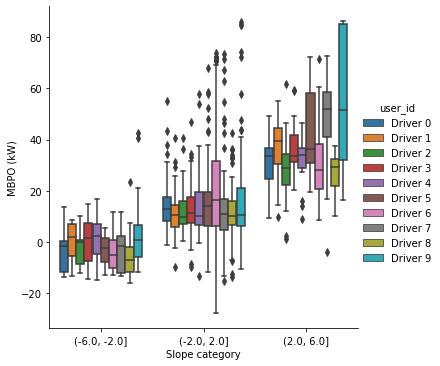

In [1198]:
sns.catplot(x='Slope category', y='MBPO (kW)', hue='user_id', data=x.sort_values(by=['user_id', 'slope' ]), kind='box')

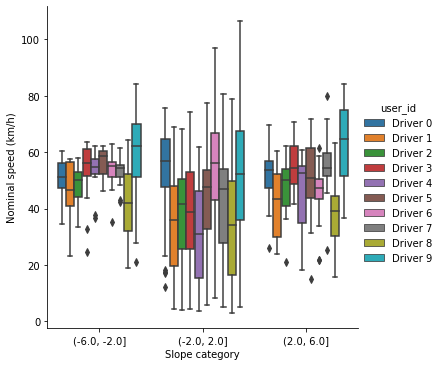

In [1199]:
sns.catplot(x='Slope category', y='Nominal speed (km/h)', hue='user_id', data=x.sort_values(by=['user_id', 'slope' ]), kind='box')

In [1201]:
from   scipy import stats

x1=x[(x['slope'] > 2) ]
x2=x[(x['slope'] > -2) & (x['slope'] <= 2)]

stat, p, med, tbl = stats.median_test(x1['Consumption rate (kWh/km)'][(x1['user_id'] == 'Driver 8')],
                                      x1['Consumption rate (kWh/km)'][(x1['user_id'] == 'Driver 3')])
print('p = ' + str(p), '\n')

# Different slope group
t2, p2 = stats.ttest_ind(x1['Consumption rate (kWh/km)'][(x1['user_id'] == 'Driver 8')] ,
                         x2['Consumption rate (kWh/km)'][x2['user_id'] == 'Driver 8' ])
print('For same user - different slope group')
print('t = ' + str(t2))
print('p = ' + str(p2), '\n')

# Same slope group > 1.7
t2, p2 = stats.ttest_ind(x1['Consumption rate (kWh/km)'][(x1['user_id'] == 'Driver 3')] ,
                         x1['Consumption rate (kWh/km)'][x1['user_id'] == 'Driver 7' ])
print('For 2 different users - slope group > 2')
print('t = ' + str(t2))
print('p = ' + str(p2), '\n')

# Same slope group > 1.7
t2, p2 = stats.ttest_ind(x1['Nominal speed (km/h)'][(x1['user_id'] == 'Driver 3')] ,
                         x1['Nominal speed (km/h)'][x1['user_id'] == 'Driver 7' ])
print('Nominal speed (km/h) For 2 different users - slope group > 2')
print('t = ' + str(t2))
print('p = ' + str(p2), '\n')

# Same slope group > 1.7
t2, p2 = stats.ttest_ind(x1['MBPO (kW)'][(x1['user_id'] == 'Driver 3')] ,
                         x1['MBPO (kW)'][x1['user_id'] == 'Driver 7' ])
print('MBPO (kW) For 2 different users - slope group > 2')
print('t = ' + str(t2))
print('p = ' + str(p2), '\n')

p = 0.0034870048921413857 

For same user - different slope group
t = 7.308564482476684
p = 4.9272801513014537e-11 

For 2 different users - slope group > 2
t = -2.1711717517761455
p = 0.038242859821446006 

Nominal speed (km/h) For 2 different users - slope group > 2
t = 0.058252425127717916
p = 0.9539471114876215 

MBPO (kW) For 2 different users - slope group > 2
t = -1.5745498442282535
p = 0.1262082072133301 



# Separate 25 km for measuring and rest for test (for the test cases)


In [481]:
features['cumdist1'] = features[(features['user_id'] == 'Santiago_Echavarria') ].kms.cumsum()  #features['cumdist'] 
features.loc[features['cumdist1'] > 25, 'user_id'] = 'Santiago_Echavarria_test'
features.loc[features['cumdist1'] < 25, 'user_id'] = 'Santiago_Echavarria_measure'

### Se utiliza para train los datos de las pruebas contraladas de todos los usuariois

In [482]:
train = features[(features['user_id'] != 'Santiago_Echavarria_test') &
                 (features['user_id'] != 'Santiago_Echavarria_measure')]
test = features.loc[features.index.difference(train.index)]

In [483]:
train.user_id.unique()

array(['Santiago_Echavarria_FSV110', 'Juan_David_Mira_Alq2',
       'Ricardo_Mejia', 'Santiago_Echavarria_01',
       'Jose_Alejandro_Montoya', 'Juan_Gregorio_Arrieta',
       'Juan_David_Mira_01', 'Mauricio_Fernandez', 'Sergio',
       'Jesus_Villa', 'Juan_David_Mira_02', 'Juan_David_Ochoa',
       'David_Rios', 'Ana_Cristina_G', 'Juan_David_Mira_03',
       'Esterban_Betancur'], dtype=object)

# Slope groups

In [487]:
slope_groups = train.groupby(by=["slope_cat"])
mean_features_by_slope = slope_groups[['max_power', 'min_power', 'consumption_per_km']].mean().reset_index()
mean_features_by_slope.rename(columns={"max_power": "mean_max_power","min_power": "mean_min_power",
                                       'consumption_per_km': 'mean_consumption_per_km','slope':'slope_cat'}, inplace=True)

mean_features_by_slope.to_csv('mean_features_by_slope.csv', index=False)


#Se lee la que se saco con segmentos de 300m.
mean_features_by_slope = pd.read_csv('mean_features_by_slope.csv')
mean_features_by_slope['slope_cat'] = mean_features_by_slope['slope_cat'].astype('string')


train_cons = pd.merge(left=train, right=mean_features_by_slope,
                      left_on='slope_cat', right_on='slope_cat')

train_cons['user_id'].unique()

array(['Santiago_Echavarria_FSV110', 'Juan_David_Mira_Alq2',
       'Ricardo_Mejia', 'Santiago_Echavarria_01',
       'Jose_Alejandro_Montoya', 'Juan_Gregorio_Arrieta',
       'Juan_David_Mira_01', 'Mauricio_Fernandez', 'Sergio',
       'Jesus_Villa', 'Juan_David_Mira_02', 'Juan_David_Ochoa',
       'David_Rios', 'Ana_Cristina_G', 'Juan_David_Mira_03',
       'Esterban_Betancur'], dtype=object)

# User and slope groups

In [491]:
slope_user_groups = train.groupby(by=['slope_cat', 'user_id'])
mean_features_by_user_and_slope = slope_user_groups[['max_power', 'min_power', 'consumption_per_km']].mean().reset_index()
mean_features_by_user_and_slope.rename(columns={"max_power": "mean_max_power_usr",
                    "min_power": "mean_min_power_usr", 'consumption_per_km': 'mean_consumption_per_km_usr'}, inplace=True)

mean_features_by_user_and_slope.to_csv('mean_features_by_user_and_slope.csv', index=False)


#Se lee la que se saco con segmentos de 300m.
mean_features_by_user_and_slope = pd.read_csv('mean_features_by_user_and_slope.csv')
mean_features_by_user_and_slope['slope_cat'] = mean_features_by_user_and_slope['slope_cat'].astype('string')

train_cons = pd.merge(left=train_cons, right=mean_features_by_user_and_slope,
                              left_on=['user_id', 'slope_cat'], right_on=['user_id', 'slope_cat'])

# Esta tabla se sacó con segmentos de 300m
mean_features_by_user_and_slope.tail(60)

,slope_cat,user_id,mean_max_power_usr,mean_min_power_usr,mean_consumption_per_km_usr
0,"(-10.0, -5.0]",David_Rios,12.452667,-20.205000,-271.100714
1,"(-10.0, -5.0]",Esterban_Betancur,15.220400,-23.230750,-342.622422
2,"(-10.0, -5.0]",Jose_Alejandro_Montoya,3.112500,-30.096500,-291.869160
3,"(-10.0, -5.0]",Juan_David_Ochoa,4.320000,-19.253500,-280.695925
4,"(-10.0, -5.0]",Juan_Gregorio_Arrieta,-0.325333,-23.787333,-389.070915
5,"(-10.0, -5.0]",Mauricio_Fernandez,5.143000,-28.905500,-407.792993
6,"(-10.0, -5.0]",Ricardo_Mejia,0.367800,-27.244000,-233.840088
7,"(-10.0, -5.0]",Santiago_Echavarria_01,6.724000,-18.739500,-227.146003
8,"(-10.0, -5.0]",Santiago_Echavarria_FSV110,-1.779846,-25.102846,-240.496479
9,"(-10.0, -5.0]",Sergio,8.269000,-15.283000,-199.801597


In [492]:
model_ft = train_cons[['mean_max_power_usr', 'mean_soc','mean_speed','slope']]
selected_ft = train_cons[['mean_max_power_usr', 'mean_soc','mean_speed', 'slope', 'consumption_per_km']]
print(len(selected_ft))
selected_ft.corr()

701


,mean_max_power_usr,mean_soc,mean_speed,slope,consumption_per_km
mean_max_power_usr,1.000000,-0.189639,0.098568,0.718647,0.668139
mean_soc,-0.189639,1.000000,-0.186061,-0.097184,-0.124044
mean_speed,0.098568,-0.186061,1.000000,0.036945,0.053855
slope,0.718647,-0.097184,0.036945,1.000000,0.906794
consumption_per_km,0.668139,-0.124044,0.053855,0.906794,1.000000


# Scaling

In [493]:
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

# For other sklearn models differente than linear regression
scaler = MinMaxScaler()
scaler.fit(train_cons[selected_ft.columns])

# For linear regression
scaler_lm = MinMaxScaler()
scaler_lm.fit(train_cons[model_ft.columns])

train_scaled = pd.DataFrame(scaler.transform(train_cons[selected_ft.columns]), columns=selected_ft.columns)

train_lm_scaled = pd.DataFrame(scaler_lm.transform(train_cons[model_ft.columns]), columns=model_ft.columns)
train_lm_scaled['consumption_per_km'] = train_scaled['consumption_per_km']

# Linear Model

In [494]:
formula = 'consumption_per_km ~ slope + mean_max_power_usr + mean_soc + mean_speed -1' # 0.84

lm_consumo = ols(formula = formula, data = train_cons[selected_ft.columns]).fit()
print(lm_consumo.summary())

                                 OLS Regression Results                                
Dep. Variable:     consumption_per_km   R-squared (uncentered):                   0.846
Model:                            OLS   Adj. R-squared (uncentered):              0.845
Method:                 Least Squares   F-statistic:                              956.7
Date:                Sun, 07 Mar 2021   Prob (F-statistic):                   2.51e-281
Time:                        23:54:20   Log-Likelihood:                         -4188.8
No. Observations:                 701   AIC:                                      8386.
Df Residuals:                     697   BIC:                                      8404.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

<Figure size 1440x1440 with 0 Axes>

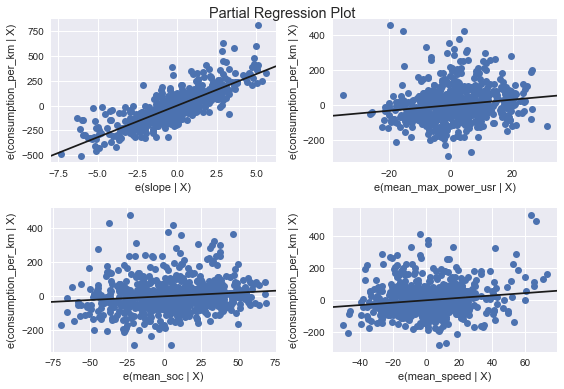

In [495]:
plt.figure(figsize =[20,20])
fig=sm.graphics.plot_partregress_grid(lm_consumo)


# Test case 2:

Aqui dividimos el set de validación en 2 partes: Santiago_Echavarria_measure y Santiago_Echavarria_test.
Santiago_Echavarria_measure contiene 25 km de manejo y se utilizará para determinar los promedios de las conductas de usuario. El conjunto Santiago_Echavarria_test contiene los siguientes kilómetros y será el conjunto donde se aplicará el algoritmo basado en los promedios calculados de Santiago_Echavarria_measure.


In [496]:


test_test = test[test['user_id']=='Santiago_Echavarria_test']
test_measure = test[test['user_id']=='Santiago_Echavarria_measure']


print(len(test_test))
print(len(test_measure))

slope_user_groups = test_measure.groupby(by=['slope_cat', 'user_id'])
mean_features_by_user_and_slope = slope_user_groups[['max_power', 'min_power', 'consumption_per_km']].mean().reset_index()
mean_features_by_user_and_slope.rename(columns={"max_power": "mean_max_power_usr",
                    "min_power": "mean_min_power_usr", 'consumption_per_km': 'mean_consumption_per_km_usr'}, inplace=True)

mean_features_by_user_and_slope.user_id = 'Santiago_Echavarria_test'
test_test = pd.merge(how='left', left=test_test, right=mean_features_by_user_and_slope,
                              left_on=['user_id', 'slope_cat'], right_on=['user_id', 'slope_cat'])
test_test


63
24


,num_acc_min,num_acc_fr_min,prom_sobrepaso_acc,prom_sobrepaso_fren,prom_abs_acc,std_acc,num_jerk_acc_min,num_jerk_freno_min,prom_sobrepaso_jerk_acc,prom_sobrepaso_jerk_freno,...,end_time,mass,lights,end_odometer,highway_enc,slope_cat,cumdist1,mean_max_power_usr,mean_min_power_usr,mean_consumption_per_km_usr
0,0.000000,0.0,1.00,1.0,0.121250,0.185838,0.000000,0.000000,1.000000,1.000000,...,2020-12-10 22:57:46,1564,0,2122.30,0,"(-5.0, 0.0]",25.475420,10.215167,-18.614333,-62.575242
1,0.000000,0.0,1.00,1.0,0.153750,0.179752,0.000000,0.000000,1.000000,1.000000,...,2020-12-10 23:02:31,1564,1,2126.60,0,"(-5.0, 0.0]",26.537507,10.215167,-18.614333,-62.575242
2,0.000000,0.0,1.00,1.0,0.130000,0.150320,0.000000,0.000000,1.000000,1.000000,...,2020-12-10 23:05:38,1564,0,2129.11,0,"(-5.0, 0.0]",27.564735,10.215167,-18.614333,-62.575242
3,0.000000,0.0,1.00,1.0,0.078571,0.089580,0.000000,0.000000,1.000000,1.000000,...,2020-12-10 23:13:02,1564,0,2134.19,4,"(0.0, 5.0]",28.619287,43.656429,-12.265643,321.298231
4,0.000000,0.0,1.00,1.0,0.047143,0.066517,0.000000,0.000000,1.000000,1.000000,...,2020-12-10 23:15:10,1564,0,2136.24,4,"(0.0, 5.0]",29.653165,43.656429,-12.265643,321.298231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.000000,0.0,1.00,1.0,0.262727,0.307523,0.000000,0.000000,1.000000,1.000000,...,2020-12-18 15:40:41,1966,1,748.00,0,"(-5.0, 0.0]",83.283978,10.215167,-18.614333,-62.575242
59,0.000000,0.0,1.00,1.0,0.284167,0.342672,0.000000,0.000000,1.000000,1.000000,...,2020-12-18 15:41:46,1966,2,748.00,0,"(-5.0, 0.0]",84.335029,10.215167,-18.614333,-62.575242
60,0.000000,0.0,1.00,1.0,0.302727,0.395547,0.000000,0.000000,1.000000,1.000000,...,2020-12-18 15:57:22,1966,0,748.00,4,"(0.0, 5.0]",85.340980,43.656429,-12.265643,321.298231
61,0.000000,0.0,1.00,1.0,0.288387,0.373179,0.000000,0.000000,1.000000,1.000000,...,2020-12-18 16:02:22,1966,5,748.00,4,"(0.0, 5.0]",86.342809,43.656429,-12.265643,321.298231


In [497]:
test_test = pd.merge(how='left', left=test_test, right=mean_features_by_slope,
                     left_on=['slope_cat'], right_on=['slope_cat'])

test_test


,num_acc_min,num_acc_fr_min,prom_sobrepaso_acc,prom_sobrepaso_fren,prom_abs_acc,std_acc,num_jerk_acc_min,num_jerk_freno_min,prom_sobrepaso_jerk_acc,prom_sobrepaso_jerk_freno,...,end_odometer,highway_enc,slope_cat,cumdist1,mean_max_power_usr,mean_min_power_usr,mean_consumption_per_km_usr,mean_max_power,mean_min_power,mean_consumption_per_km
0,0.000000,0.0,1.00,1.0,0.121250,0.185838,0.000000,0.000000,1.000000,1.000000,...,2122.30,0,"(-5.0, 0.0]",25.475420,10.215167,-18.614333,-62.575242,16.879774,-18.812176,-26.805638
1,0.000000,0.0,1.00,1.0,0.153750,0.179752,0.000000,0.000000,1.000000,1.000000,...,2126.60,0,"(-5.0, 0.0]",26.537507,10.215167,-18.614333,-62.575242,16.879774,-18.812176,-26.805638
2,0.000000,0.0,1.00,1.0,0.130000,0.150320,0.000000,0.000000,1.000000,1.000000,...,2129.11,0,"(-5.0, 0.0]",27.564735,10.215167,-18.614333,-62.575242,16.879774,-18.812176,-26.805638
3,0.000000,0.0,1.00,1.0,0.078571,0.089580,0.000000,0.000000,1.000000,1.000000,...,2134.19,4,"(0.0, 5.0]",28.619287,43.656429,-12.265643,321.298231,32.965684,-14.210620,215.498345
4,0.000000,0.0,1.00,1.0,0.047143,0.066517,0.000000,0.000000,1.000000,1.000000,...,2136.24,4,"(0.0, 5.0]",29.653165,43.656429,-12.265643,321.298231,32.965684,-14.210620,215.498345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.000000,0.0,1.00,1.0,0.262727,0.307523,0.000000,0.000000,1.000000,1.000000,...,748.00,0,"(-5.0, 0.0]",83.283978,10.215167,-18.614333,-62.575242,16.879774,-18.812176,-26.805638
59,0.000000,0.0,1.00,1.0,0.284167,0.342672,0.000000,0.000000,1.000000,1.000000,...,748.00,0,"(-5.0, 0.0]",84.335029,10.215167,-18.614333,-62.575242,16.879774,-18.812176,-26.805638
60,0.000000,0.0,1.00,1.0,0.302727,0.395547,0.000000,0.000000,1.000000,1.000000,...,748.00,4,"(0.0, 5.0]",85.340980,43.656429,-12.265643,321.298231,32.965684,-14.210620,215.498345
61,0.000000,0.0,1.00,1.0,0.288387,0.373179,0.000000,0.000000,1.000000,1.000000,...,748.00,4,"(0.0, 5.0]",86.342809,43.656429,-12.265643,321.298231,32.965684,-14.210620,215.498345


In [498]:
test_test[['user_id', 'slope_cat']] = test_test[['user_id', 'slope_cat']].astype('string')

In [499]:
#mean_max_pot_per_user_and_slope['slope_cat'] = mean_max_pot_per_user_and_slope['slope_cat'].astype('string')

In [500]:
# test_consolidated = pd.merge(how='left', left=test_consolidated, right=mean_max_pot_per_user_and_slope,
#                               left_on=['slope_cat', 'user_id'], right_on=['slope_cat', 'user_id'])
# test_consolidated

In [501]:
test_test['mean_max_power_usr'] = test_test.apply(
    lambda row: row['mean_max_power'] if np.isnan(row['mean_max_power_usr']) else row['mean_max_power_usr'],
    axis=1
)
test_test.isna().sum()

num_acc_min                    0
num_acc_fr_min                 0
prom_sobrepaso_acc             0
prom_sobrepaso_fren            0
prom_abs_acc                   0
std_acc                        0
num_jerk_acc_min               0
num_jerk_freno_min             0
prom_sobrepaso_jerk_acc        0
prom_sobrepaso_jerk_freno      0
prom_abs_jerk                  0
std_jerk                       0
std_power                      0
prom_abs_power                 0
consumption                    0
kms                            0
consumption_per_km             0
num_current_min                0
num_current_fr_min             0
prom_sobrepaso_current         0
prom_sobrepaso_current_fr      0
prom_abs_current               0
std_current                    0
std_current_std_jerk           0
highway                        0
slope                          0
nominal_speed                  0
max_current                    0
max_jerk                       0
max_acc                        0
max_power 

In [502]:
print(test_test[['mean_max_power_usr', 'mean_soc','mean_speed', 'slope']].isna().sum() )
test_scaled = pd.DataFrame(scaler_lm.transform(test_test[model_ft.columns]), columns=model_ft.columns)
test_scaled[['mean_max_power_usr', 'mean_soc','mean_speed', 'slope']].isna().sum()

mean_max_power_usr    0
mean_soc              0
mean_speed            0
slope                 0
dtype: int64


mean_max_power_usr    0
mean_soc              0
mean_speed            0
slope                 0
dtype: int64

In [503]:
y_test = pd.DataFrame(scaler.transform(test_test[selected_ft.columns]), columns=selected_ft.columns)['consumption_per_km']

predictions = lm_consumo.predict(test_scaled)



### Without scaling

In [437]:
test_test['consumption_per_km'] = test_test['consumption_per_km']*1000
predictions = lm_consumo.predict(test_test[['mean_max_power_usr', 'mean_soc','mean_speed', 'slope']])
y_test = test_test['consumption_per_km']

## Save Linear Model

In [414]:
dump(lm_consumo, open('linear_model.pkl', 'wb'))

RMSE = 72.7225885303418
R2 = 0.8197929830125776
max error= 179.7118948571286


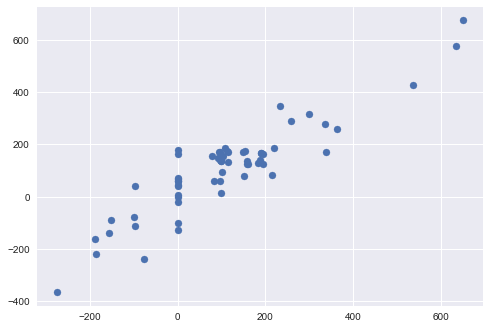

In [431]:
def model_evaluation(y_test, predictions):
    RMSE = np.sqrt(mean_squared_error(y_test, predictions))
    print('RMSE =',RMSE)

    print('R2 =',r2_score(y_test, predictions))
    print('max error=',max(abs(y_test - predictions)))
    plt.figure()
    plt.scatter(x=y_test, y=predictions)

model_evaluation(y_test, predictions)

# Random forest

In [504]:
y_test

0     0.202314
1     0.200515
2     0.267620
3     0.409397
4     0.410796
        ...   
58    0.411801
59    0.339439
60    0.456780
61    0.457263
62    0.456508
Name: consumption_per_km, Length: 63, dtype: float64

RMSE = 0.052729855822756036
R2 = 0.8259267745968448
max error= 0.13961972832764452


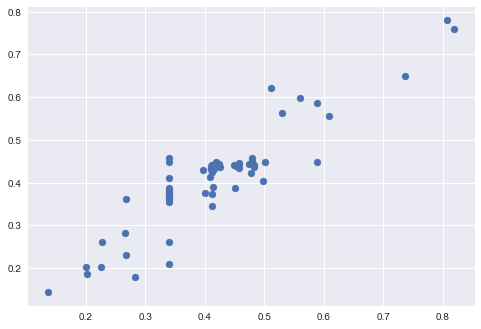

In [519]:
X = train_lm_scaled[['mean_max_power_usr', 'mean_soc','mean_speed', 'slope']].values
y = train_lm_scaled['consumption_per_km'].values

# Step 1
# n_estimators=[,,,,,], max_depth=[,,,,,,]

# Curva de aprendizaje
# Variar train size 

# Curva de complejidad
# x cada uno de los parámetros max_depth': 110, 'max_samples': 0.2, 'n_estimators': 45}
randF_regr = RandomForestRegressor(n_estimators=50, max_depth=8,
                                   random_state=0,max_features='auto' , criterion='mse', max_samples = 0.1)

randF_regr.fit(X, y)
y_pred = randF_regr.predict(test_scaled[['mean_max_power_usr', 'mean_soc', 'mean_speed', 'slope']].values)
model_evaluation(y_test, y_pred)

In [156]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
print("Initialize Grid Search")
param_grid = { 
    'n_estimators': np.arange(5,70,5),
    'max_depth' : np.arange(2,20,2),
    'max_samples' : np.arange(0.1,0.9,0.1)
}
# create and fit a regression model, testing each parameter value

 

model = RandomForestRegressor()
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid.fit(X, y)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_params_)

Initialize Grid Search
GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                         'max_samples': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                         'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65])})
0.5765891229637505
{'max_depth': 8, 'max_samples': 0.1, 'n_estimators': 20}


# Complexity curves

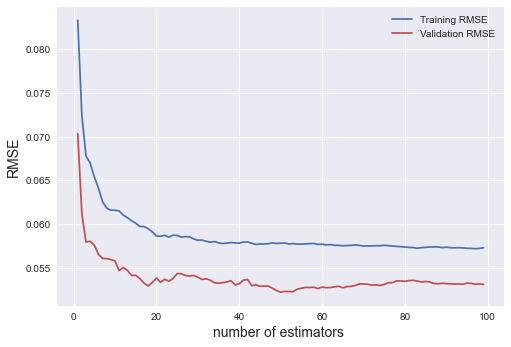

In [517]:
from sklearn.metrics import mean_absolute_error

n_estimators = np.arange(1,100,1)
X_test = test_scaled[['mean_max_power_usr', 'mean_soc','mean_speed', 'slope']].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for estimators in n_estimators:
    reg = RandomForestRegressor(n_estimators = estimators, max_features='auto', max_depth=8, max_samples = 0.12,
                                criterion = 'mse', random_state = 0)
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(n_estimators, train_acc, 'b', label = 'Training RMSE')
plt.plot(n_estimators, val_acc, 'r', label = 'Validation RMSE')
# plt.plot(n_estimators, train_r2, 'c', label = 'Training MAE')
# plt.plot(n_estimators, val_r2, 'y', label = 'Validation MAE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('number of estimators ', fontsize = 14)
# plt.title('Complexity curves for random forest', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [518]:
n_estimators[val_acc.index(min(val_acc))]


50

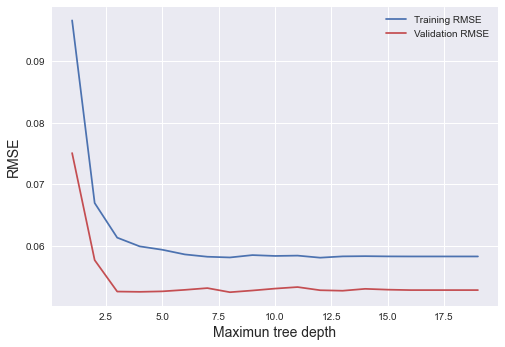

In [509]:
depths = np.arange(1,20,1)
X_test = test_scaled[['mean_max_power_usr', 'mean_soc','mean_speed', 'slope']].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for depth in depths:
    reg = RandomForestRegressor(n_estimators = 53, max_features='auto', max_samples = 0.1,
                                max_depth=depth, criterion = 'mse', random_state = 0, n_jobs=-1)
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(depths, train_acc, 'b', label = 'Training RMSE')
plt.plot(depths, val_acc, 'r', label = 'Validation RMSE')
# plt.plot(n_estimators, train_r2, 'c', label = 'Training MAE')
# plt.plot(n_estimators, val_r2, 'y', label = 'Validation MAE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Maximun tree depth', fontsize = 14)
# plt.title('Complexity curves for random forest', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [510]:
depths[val_acc.index(min(val_acc))]


8

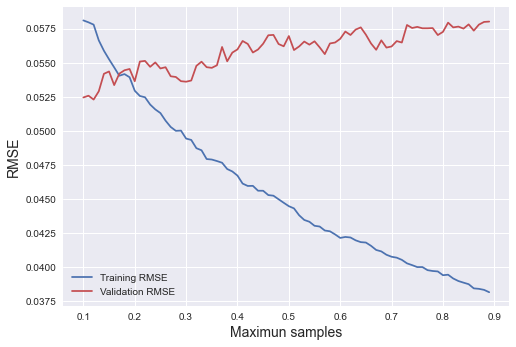

In [514]:
max_samples = np.arange(0.1,0.9,0.01)
X_test = test_scaled[['mean_max_power_usr', 'mean_soc','mean_speed', 'slope']].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for max_sample in max_samples:
    reg = RandomForestRegressor(n_estimators = 53, max_features='auto', max_samples = max_sample,
                                max_depth=8, criterion = 'mse', random_state = 0, n_jobs=-1)
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(max_samples, train_acc, 'b', label = 'Training RMSE')
plt.plot(max_samples, val_acc, 'r', label = 'Validation RMSE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Maximun samples', fontsize = 14)
# plt.title('Complexity curves for random forest', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [515]:
max_samples[val_acc.index(min(val_acc))]

0.12

Text(0.5, 0, 'Relative Importance')

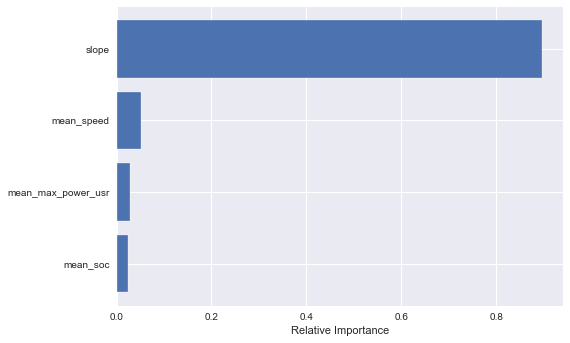

In [520]:
features=train_lm_scaled.columns[[0, 1, 2, 3]]
importances = randF_regr.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
#plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [521]:
dump(randF_regr, open('randomForest_0_13_mean_consumption_maxerr_model.pkl', 'wb'))
dump(scaler, open('scaler.pkl', 'wb'))
dump(scaler_lm, open('scaler_lm.pkl', 'wb'))

# XGBoost

RMSE = 0.05431293941299329
R2 = 0.8153176366288302
max error= 0.1395690132735523


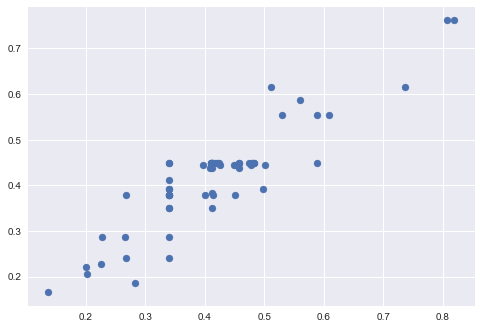

In [522]:
## 
data_dmatrix = xgb.DMatrix(data=X,label=y)

# xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8, learning_rate = 0.5,
#                 max_depth = 10, n_estimators = 5)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8, learning_rate = 0.15,
                max_depth = 2, n_estimators = 18)


xg_reg.fit(X, y)

y_pred_xgb = xg_reg.predict(test_scaled[['mean_max_power_usr', 'mean_soc', 'mean_speed', 'slope']].values)
model_evaluation(y_test, y_pred_xgb)

# Save the model
dump(xg_reg, open('xg_reg_model.pickle.dat', 'wb'))


In [543]:
from sklearn.model_selection import RandomizedSearchCV
print("Initialize Grid Search")
param_distributions = { 
    'colsample_bytree' : np.arange(0.1, 1, 0.1),
    'learning_rate' : np.arange(0.1, 1, 0.1),
    'n_estimators': [2,3,4,5],
    'max_depth' : np.arange(10, 30, 2),
    'objective' :['reg:squarederror']
}
# create and fit a regression model, testing each parameter value

 
#     'n_estimators': np.arange(3,60,1),
#     'max_depth' : np.arange(3,40,1),
model = xgb.XGBRegressor()
grid = GridSearchCV(estimator=model, param_grid=param_distributions, n_jobs=-1)
grid.fit(X, y)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_params_)

Initialize Grid Search
GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,...
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_jobs=-1,
             param_grid={'colsample_bytree': array(

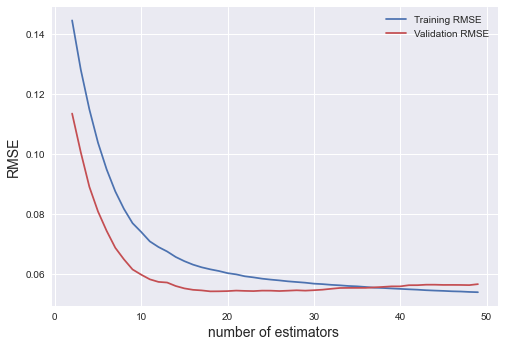

In [523]:
n_estimators = np.arange(2,50,1)
X_test = test_scaled[['mean_max_power_usr', 'mean_soc','mean_speed', 'slope']].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for estimators in n_estimators:
    
    reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.75, learning_rate = 0.15,
                max_depth = 2, n_estimators = estimators, n_jobs=-1)

    
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(n_estimators, train_acc, 'b', label = 'Training RMSE')
plt.plot(n_estimators, val_acc, 'r', label = 'Validation RMSE')
# plt.plot(n_estimators, train_r2, 'c', label = 'Training MAE')
# plt.plot(n_estimators, val_r2, 'y', label = 'Validation MAE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('number of estimators ', fontsize = 14)
#plt.title('Complexity curves for xgboost', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [524]:
# El valor óptimo
n_estimators[val_acc.index(min(val_acc))]

18

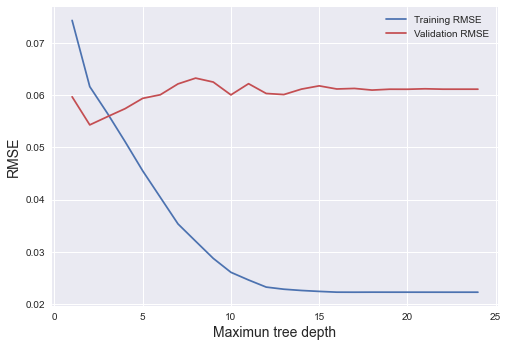

In [525]:
depths = np.arange(1,25,1)
X_test = test_scaled[['mean_max_power_usr', 'mean_soc','mean_speed', 'slope']].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for depth in depths:
    
    reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.75, learning_rate = 0.15,
                max_depth = depth, n_estimators = 18, n_jobs=-1) 
    
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(depths, train_acc, 'b', label = 'Training RMSE')
plt.plot(depths, val_acc, 'r', label = 'Validation RMSE')
# plt.plot(n_estimators, train_r2, 'c', label = 'Training MAE')
# plt.plot(n_estimators, val_r2, 'y', label = 'Validation MAE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Maximun tree depth', fontsize = 14)
#plt.title('Complexity curves for random forest', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [374]:
depths[val_acc.index(min(val_acc))]

2

#### Percentage of columns samples by tree

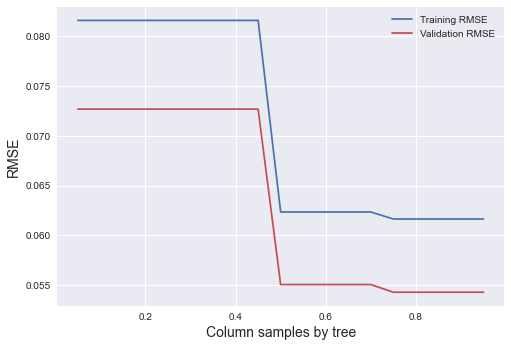

In [381]:
colsamples_bytree = np.arange(0.05,1,0.05)
X_test = test_scaled[['mean_max_power_usr', 'mean_soc','mean_speed', 'slope']].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for colsample_bytree in colsamples_bytree:
    
    reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = colsample_bytree, learning_rate = 0.15,
                max_depth = 2, n_estimators = 18, n_jobs=-1) 
    
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(colsamples_bytree, train_acc, 'b', label = 'Training RMSE')
plt.plot(colsamples_bytree, val_acc, 'r', label = 'Validation RMSE')
# plt.plot(n_estimators, train_r2, 'c', label = 'Training MAE')
# plt.plot(n_estimators, val_r2, 'y', label = 'Validation MAE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Column samples by tree', fontsize = 14)
#plt.title('Complexity curves for random forest', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [376]:
colsamples_bytree[val_acc.index(min(val_acc))]

0.7500000000000001

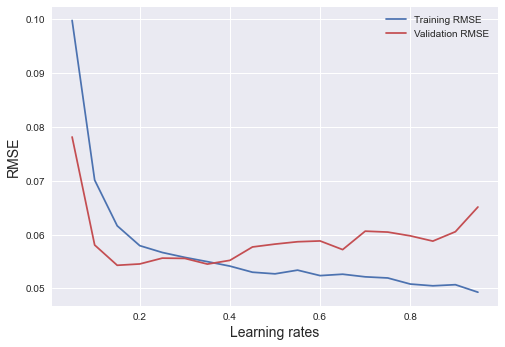

In [379]:
learning_rates = np.arange(0.05,1,0.05)
X_test = test_scaled[['mean_max_power_usr', 'mean_soc','mean_speed', 'slope']].values

train_reg_results = []
validation_reg_results = []
train_reg_r2 = []
validation_reg_r2 = []

train_acc = []
val_acc = []
val_r2 = []
train_r2 = []

for learning_rate in learning_rates:
    
    reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.8, learning_rate = learning_rate,
                max_depth = 2, n_estimators = 18, n_jobs=-1) 
    
    reg.fit(X, y)
    # Predicting the Traint set results
    y_pred_train = reg.predict(X)
    train_reg_results.append(np.sqrt(mean_squared_error(y, y_pred_train)))

    y_pred = reg.predict(X_test)
    validation_reg_results.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    
    train_reg_r2.append(mean_absolute_error(y, y_pred_train))

    validation_reg_r2.append(mean_absolute_error(y_test, y_pred))

    #print('R2 =',r2_score(y_test, predictions))

for i in range(len(train_reg_results)):
    train_acc.append(train_reg_results[i])
    val_acc.append(validation_reg_results[i])
    train_r2.append(train_reg_r2[i])
    val_r2.append(validation_reg_r2[i])


plt.figure('Complexity curve')
plt.style.use('seaborn')
plt.plot(learning_rates, train_acc, 'b', label = 'Training RMSE')
plt.plot(learning_rates, val_acc, 'r', label = 'Validation RMSE')
# plt.plot(n_estimators, train_r2, 'c', label = 'Training MAE')
# plt.plot(n_estimators, val_r2, 'y', label = 'Validation MAE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('Learning rates', fontsize = 14)
#plt.title('Complexity curves for random forest', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

In [380]:
learning_rates[val_acc.index(min(val_acc))]

0.15000000000000002

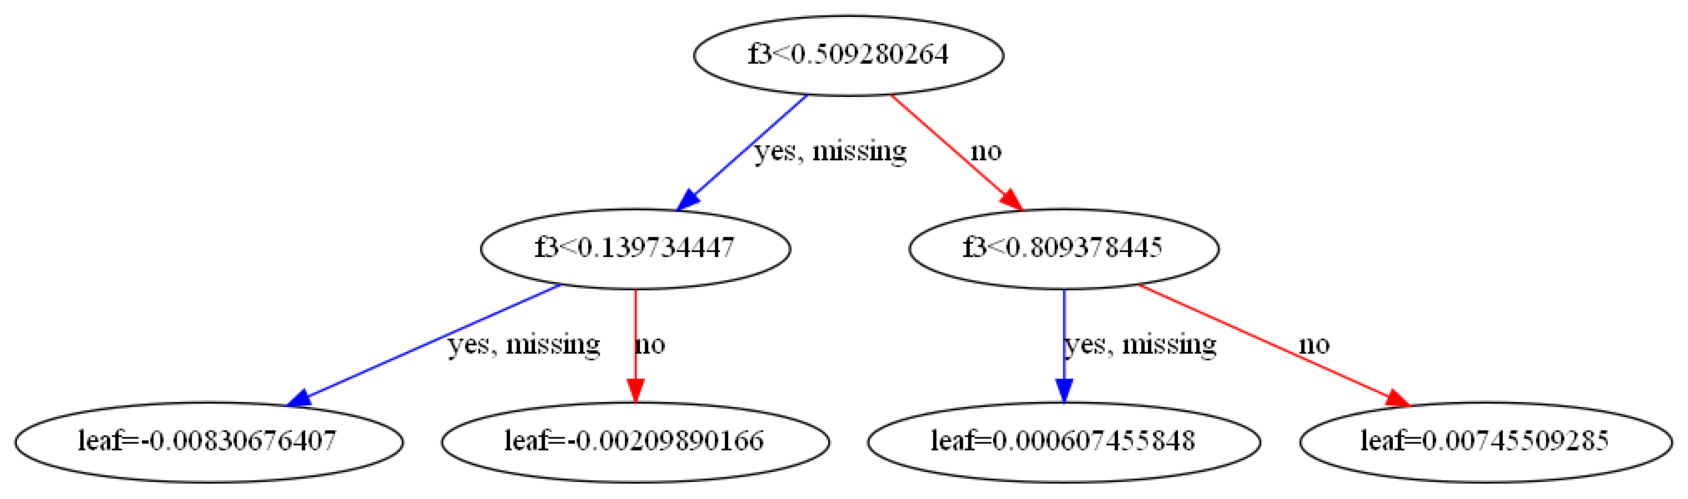

In [526]:
ax = xgb.plot_tree(xg_reg,num_trees=17)
fig = ax.figure
fig.set_size_inches(30, 35)
# fig = plot.get_figure()
# fig.savefig('test2png.png')

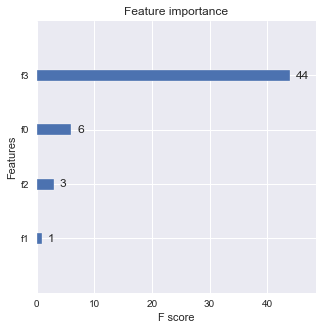

In [527]:
ax = xgb.plot_importance(xg_reg)
fig = ax.figure
fig.set_size_inches(5, 5)

In [570]:
params = {"objective":"reg:squarederror",'colsample_bytree': 1,'learning_rate': 0.1,
                'max_depth': 2, 'n_estimators': 24}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results

[16:47:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:47:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:47:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in la

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.184703,0.004767,0.184698,0.010201
1,0.169717,0.004059,0.170144,0.009442
2,0.156368,0.003339,0.157335,0.008304
3,0.144503,0.002710,0.145643,0.007433
4,0.134017,0.002161,0.135426,0.006475
5,0.124490,0.001644,0.126578,0.005556
6,0.116143,0.001114,0.118821,0.004802
7,0.108731,0.000760,0.111768,0.004038
8,0.102275,0.000452,0.105651,0.003612
9,0.096525,0.000226,0.100514,0.003175


# sklearn linear model

RMSE = 0.05347072956936692
R2 = 0.8210008254408472
max error= 0.13632937232930575


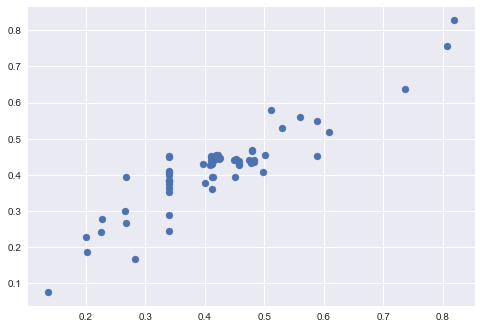

In [528]:
X = train_lm_scaled[['mean_max_power_usr','mean_soc','mean_speed', 'slope']].values
y = train_lm_scaled['consumption_per_km'].values

from sklearn import linear_model

linear_regr = linear_model.LinearRegression(n_jobs=-1)

linear_regr.fit(X, y)
y_pred_linear = linear_regr.predict(test_scaled[['mean_max_power_usr','mean_soc', 'mean_speed', 'slope']].values)
model_evaluation(y_test, y_pred_linear)

# Ann

RMSE = 0.05351349228986501
R2 = 0.8207144050932242
max error= 0.1346970958677432


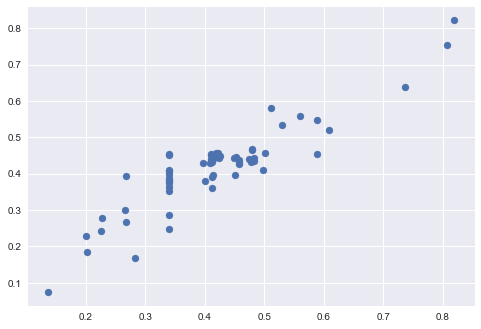

In [534]:
X = train_lm_scaled[['mean_max_power_usr','mean_soc','mean_speed', 'slope']].values
y = train_lm_scaled['consumption_per_km'].values

from sklearn.neural_network import MLPRegressor

ann_regr = MLPRegressor(random_state=1, activation='logistic', alpha=0, hidden_layer_sizes= (100), max_iter=70500, solver='lbfgs').fit(X, y)

#regr = MLPRegressor(random_state=1, max_iter=500, solver='lbfgs', activation='relu', alpha=0.002, hidden_layer_sizes=(150,)).fit(X, y)
y_ann=ann_regr.predict(test_scaled[['mean_max_power_usr','mean_soc', 'mean_speed', 'slope']].values)
ann_regr.score(test_scaled[['mean_max_power_usr','mean_soc','mean_speed', 'slope']].values, y_test)

model_evaluation(y_test, y_ann)


In [389]:
print("Initialize Grid Search")
param_grid = { 
    'solver':['lbfgs'],
     #arning_rate': ["constant", "invscaling", "adaptive"],
    'hidden_layer_sizes': [(150,100), (150,)],
    'activation': ["logistic"],
    'max_iter':[10500],
    }


# create and fit a regression model, testing each parameter value


model = MLPRegressor()
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid.fit(X, y)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_params_)

Initialize Grid Search
GridSearchCV(estimator=MLPRegressor(),
             param_grid={'activation': ['logistic'],
                         'hidden_layer_sizes': [(150, 100), (150,)],
                         'max_iter': [10500], 'solver': ['lbfgs']})
0.6618003787286298
{'activation': 'logistic', 'hidden_layer_sizes': (150, 100), 'max_iter': 10500, 'solver': 'lbfgs'}


# Learning curve

max =  -0.06319065865689427
max =  -0.06675274359173433


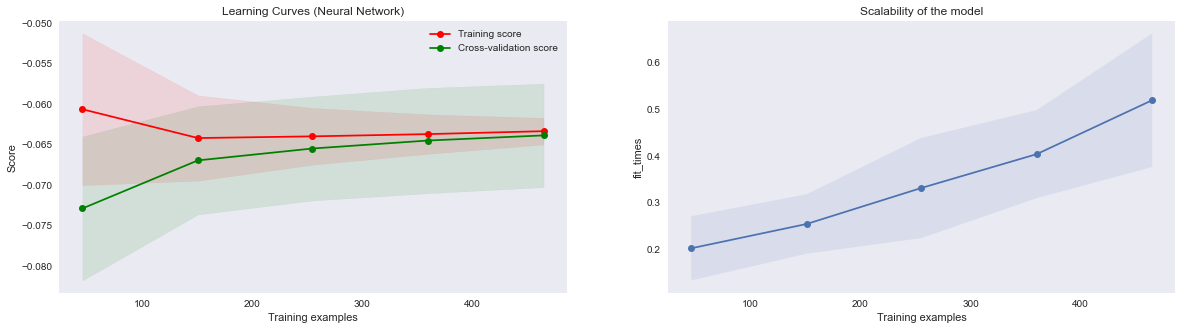

max =  -0.034869619071199516
max =  -0.0673033548590443


<Figure size 576x396 with 0 Axes>

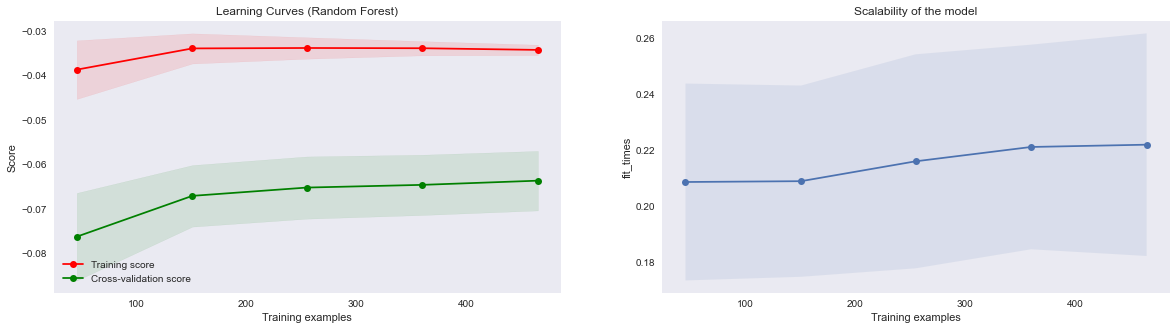

max =  -0.06419651326148074
max =  -0.0672606083116413


<Figure size 576x396 with 0 Axes>

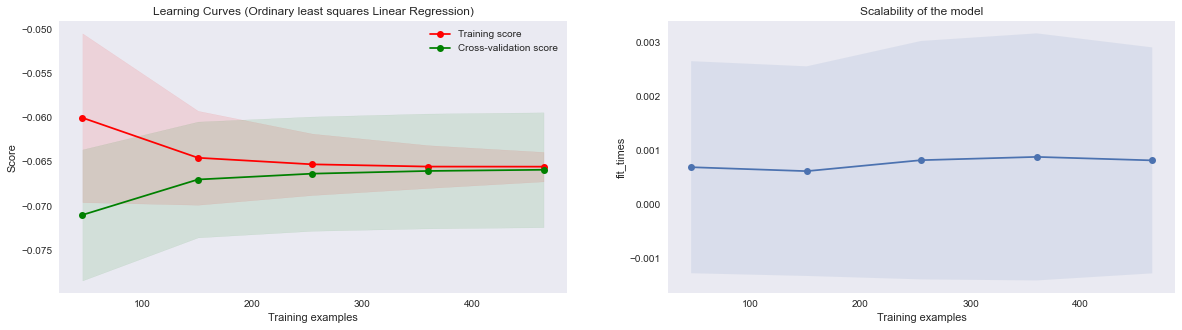

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
 
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].set_title(title)
    #if ylim is not None:
        #axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, scoring='neg_root_mean_squared_error')
    train_scores_mean = np.mean(train_scores, axis=1)
    print('max = ', np.mean(train_scores))
    print('max = ', np.mean(test_scores))
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    '''
    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, np.sort(test_scores_mean), 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    '''
    return plt


title = "Learning Curves (Neural Network)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = MLPRegressor(random_state=1, activation='logistic', alpha=0.001, hidden_layer_sizes= (150,30),
                         max_iter=10500, solver='lbfgs')
plot_learning_curve(estimator, title, X, y, # ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)
plt.show()

plt.figure()
title = "Learning Curves (Random Forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = RandomForestRegressor(n_estimators=60, max_depth=10,
                                   min_samples_leaf=2,max_features='auto' , criterion='mse', n_jobs=-1)
plot_learning_curve(estimator, title, X, y, # ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

plt.show()

plt.figure()
title = "Learning Curves (Ordinary least squares Linear Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = linear_model.LinearRegression(n_jobs=-1)
plot_learning_curve(estimator, title, X, y,  # ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

plt.show()


In [535]:
dump(ann_regr, open('ann_regr.pkl', 'wb'))
